In [1]:
import sys, csv, re, datetime, itertools, collections, math
import numpy as np
import scipy.stats
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def merge(dict1, dict2):
    Cdict = collections.defaultdict(int)
    for key, val in itertools.chain(dict1.items(), dict2.items()):
        Cdict[key] += val
    return Cdict


file_names = {"case": "data/time_series_covid19_confirmed_global.csv", "recover": "data/time_series_covid19_recovered_global.csv", "death": "data/time_series_covid19_deaths_global.csv"}
types = ["case", "recover", "death"]
ROW_CASE, ROW_RECOVER, ROW_DEATH = 0, 1, 2

country_data_raw = {}
for n, fn in file_names.items():
#         data_raw[n] = collections.defaultdict(int)
        with open(fn, 'r') as f:
                r = csv.DictReader(f, delimiter=',', quotechar='"')
                for row in r:
#                         if row["Country/Region"] == country:
                        dd = { datetime.datetime.strptime(d, "%m/%d/%y").date() : int(v) for d,v in row.items() if re.match('\d+/\d+/\d+', d) }
                        c = row["Country/Region"]
                        if c not in country_data_raw:
                            country_data_raw[c] = {}
                        if not n in country_data_raw[c]:
                            country_data_raw[c][n] = collections.defaultdict(int)
                        country_data_raw[c][n] = merge(country_data_raw[c][n], dd)
                                
countries = list(country_data_raw.keys())

first_date_before_pass = max([min(l.keys()) for country, data_raw in country_data_raw.items() for n, l in data_raw.items() ])
last_date = min([max(l.keys()) for country, data_raw in country_data_raw.items() for n, l in data_raw.items() ])
n_before_pass = (last_date - first_date_before_pass).days
pass_days = 30
first_date = first_date_before_pass + datetime.timedelta(days=pass_days)
n = (last_date - first_date).days

country_datacum = {c:np.zeros((3, n)) for c in countries}
country_data = {c:np.zeros((3, n)) for c in countries}
for c, data_raw in country_data_raw.items():
    for i, t in enumerate(types):
            for j in range(n):
                    country_datacum[c][i,j] = data_raw[t][first_date + datetime.timedelta(days=j)]
                    country_data[c][i,j] = data_raw[t][first_date + datetime.timedelta(days=j)] - data_raw[t][first_date + datetime.timedelta(days=j-1)]
    #         data_cumsum = np.cumsum(data[i,:])
    #         data[i,7:n] = data_cumsum[7:(n)] - data_cumsum[0:(n-7)]
    #         data[i,0:7] = data_cumsum[0:7]


In [2]:
# Load population
country_name_correction = {'Iran, Islamic Rep.' : 'Iran'}

country_population = {}
country_population_year = {}
with open("data/population.csv", 'r') as f:
        r = csv.DictReader(f, delimiter=',', quotechar='"')
        for row in r:
                c, y, v = row["Country Name"], int(row["Year"]), int(row["Value"])
                if c in country_name_correction: c = country_name_correction[c]
                if c not in country_population:
                    country_population[c], country_population_year[c] = v, y
                else:
                    if y > country_population_year[c]:
                        country_population[c], country_population_year[c] = v, y

#print(country_population)

# Load number of tests for each country on each day

In [3]:
# Load number of tests for each country on each day
country_test_count = {}
# country_case_count = {}
with open("data/owid-covid-data.csv", 'r') as f:
        r = csv.DictReader(f, delimiter=',', quotechar='"')
        for row in r:
                c, d = row["location"], datetime.datetime.strptime(row["date"], "%Y-%m-%d").date()
                if c not in country_test_count: country_test_count[c] = {}
                if row["new_tests"] != '':
                    country_test_count[c][d] = math.floor(float(row["new_tests"]))
#                 if c not in country_case_count: country_case_count[c] = {}
#                 if row["new_cases"] != '':
#                     country_case_count[c][d] = math.floor(float(row["new_cases"]))

#                case[c][ datetime.datetime.strptime(row["date"], "%Y-%m-%d").date() ] = math.floor(float(row["new_cases"]))
                    
# #print(country_test_count.keys())
# plt.plot(country_test_count["Iran"].keys(), country_test_count["Iran"].values(), label='Iran')
# plt.plot(country_test_count["United Kingdom"].keys(), country_test_count["United Kingdom"].values(), label='Germany')

# #test

In [4]:
def norm_statistics(data):
        m = np.mean(data)
        v = np.var(data)
        dist = scipy.stats.norm(m, v)
        likelihood = np.sum([dist.logpdf(x) for x in data])
        return m, v, likelihood


def log_fatality_ratio_estimate(range_st, range_ed, infection_to_death, country):
    return np.log(country_data[country][ROW_DEATH, (range_st):(range_ed)]) - np.log(country_data[country][ROW_CASE, (range_st-infection_to_death):(range_ed-infection_to_death)])


def log_fatality_ratio_estimate_cum(range_st, range_ed, infection_to_death, country):
    return np.log(country_datacum[country][ROW_DEATH, (range_st):(range_ed)]) - np.log(country_datacum[country][ROW_CASE, (range_st-infection_to_death):(range_ed-infection_to_death)])

#for k, l in data.items():
        #print("{}: {}".format(k, sorted(l.keys())))
        #print("{}: {}".format(k, l))
#FIT THE FIRST MODEL:                                                                            
def estimate_one_normal_model(d_min, d_max, range_st, range_ed, country):
    likelihood_max, fatality_ratio_ret, infection_to_death_ret = -1e10, None, None

    # fig = plt.figure(figsize=(8, 30), dpi=80)
    # gs = fig.add_gridspec((d_max - d_min) // 10, hspace=0)
    # axs = gs.subplots(sharex=True, sharey=True)

    likelihoods = []
    for d in range(d_min,d_max):
        fatality_ratio, v, likelihood = norm_statistics(log_fatality_ratio_estimate(range_st, range_ed, d, country))
        if likelihood > likelihood_max:
                fatality_ratio_ret, infection_to_death_ret, likelihood_max = fatality_ratio, d, likelihood
        likelihoods.append(likelihood)
    return np.exp(fatality_ratio_ret), infection_to_death_ret, likelihood_max
    #     if (d-d_min) % 10 == 0:
    #         axs[(d-d_min) // 10].hist(ddlog, bins=30)
    # fig.show()

#days_infection_to_death = 23
#infection_fatality_ratio = 100

def estimate_two_normals_model(d_min, d_max, range_st, range_ed, country):
    likelihood_max, fatality_ratio_ret, infection_to_death_ret, break_ret = -1e10, None, None, None
    likelihoods = []
    for d in range(d_min, d_max):
        for b in range(range_st+1, range_ed-1):
            fatality_ratio_1, v_1, likelihood_1 = norm_statistics(log_fatality_ratio_estimate(range_st, b, d, country))
            fatality_ratio_2, v_2, likelihood_2 = norm_statistics(log_fatality_ratio_estimate(b, range_ed, d, country))
            if likelihood_1 + likelihood_2 > likelihood_max:
                    fatality_ratio_ret, infection_to_death_ret, break_ret, likelihood_max = (fatality_ratio_1, fatality_ratio_2), d, b, likelihood_1 + likelihood_2
            likelihoods.append(likelihood_1 + likelihood_2)
    return np.exp(fatality_ratio_ret), infection_to_death_ret, break_ret, likelihood_max
    #     if (d-d_min) % 10 == 0:
    #         axs[(d-d_min) // 10].hist(ddlog, bins=30)
    # fig.show()

def liklihood_ratio_test(llmin, llmax, param_diff):
    lr = (2*(llmax-llmin))
    p = scipy.stats.distributions.chi2.sf(lr, param_diff)
    return p


In [70]:
e1_fr, e1_itd, e1_ll = estimate_one_normal_model(20, 200, 300, n)

In [72]:
e2_fr, e2_itd, e2_b, e2_ll = estimate_two_normals_model(e1_itd, e1_itd+1, 300, n)

In [73]:
infection_to_death = 90
print(e1_fr, e1_itd, e1_ll)
print(e2_fr, e2_itd, e2_b, e2_ll)

0.04272453322983323 149 -122.61323880912406
[0.04623434 0.0124025 ] 149 394 -126.53048814257342


In [ ]:
d_min, d_max, range_st, range_ed = 0, 200, 300, n
likelihood_max, fatality_ratio_ret, infection_to_death_ret = -1e10, None, None

# fig = plt.figure(figsize=(8, 30), dpi=80)
# gs = fig.add_gridspec((d_max - d_min) // 10, hspace=0)
# axs = gs.subplots(sharex=True, sharey=True)

likelihoods = []
for d in range(d_min,d_max):
    dd = data[ROW_DEATH, (range_st):(range_ed)] / data[ROW_CASE, (range_st-d):(range_ed-d)]
    ddlog = np.log(dd)
    fatality_ratio = np.mean(ddlog)
    v = np.var(ddlog)
    dist = scipy.stats.norm(fatality_ratio, v)
    likelihood = np.sum([dist.logpdf(x) for x in ddlog])
    #print(d, fatality_ratio, fitness)
    if likelihood > likelihood_max:
            fatality_ratio_ret, infection_to_death_ret, likelihood_max = fatality_ratio, d, likelihood
    likelihoods.append(likelihood)
#     if (d-d_min) % 10 == 0:
#         axs[(d-d_min) // 10].hist(ddlog, bins=30)
# fig.show()

plt.plot(range(d_min,d_max), likelihoods)


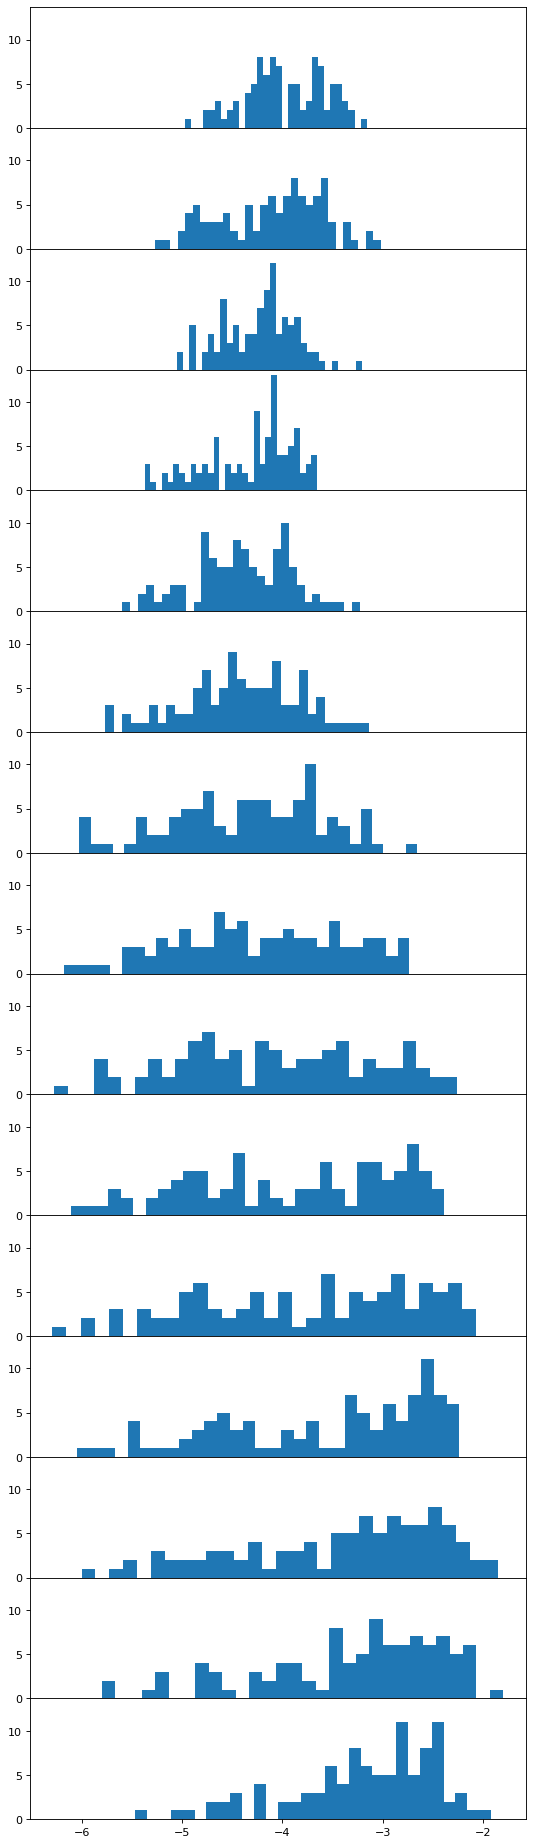

In [74]:
# range_st, range_ed, infection_to_death = 300, n, 10
# dd = np.log(data[ROW_DEATH, (range_st):(range_ed)]) - np.log(data[ROW_CASE, (range_st-infection_to_death):(range_ed-infection_to_death)])

d_min, d_max, d_step = 0, 150, 10

fig = plt.figure(figsize=(8, 30), dpi=80)
gs = fig.add_gridspec((d_max - d_min) // d_step, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

for d in range(d_min, d_max, d_step):
    dd = log_fatality_ratio_estimate(300, n, d)
    axs[(d-d_min) // d_step].hist(dd, bins=30)

fig.show()

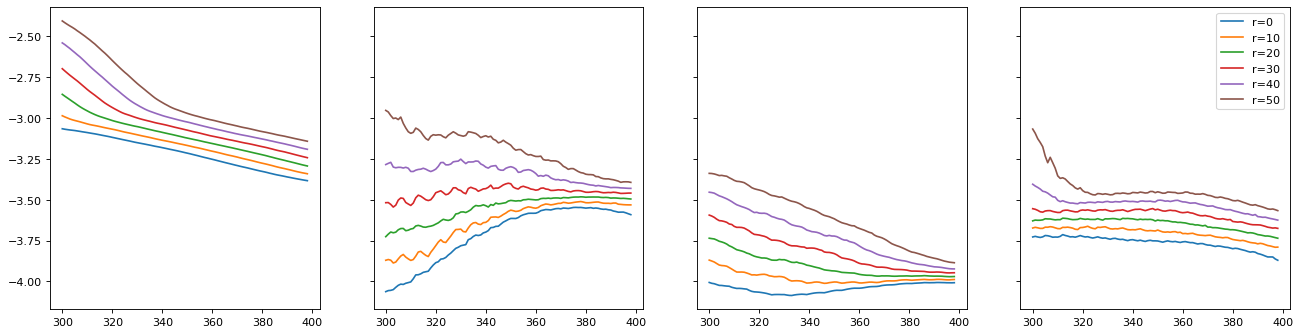

In [11]:
fig = plt.figure(figsize=(20, 5), dpi=80)
gs = fig.add_gridspec(1, 4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

for infection_to_death in range(0, 60, 10):
    dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'Iran')
    axs[0].plot(range(300, n), dd, label="r={}".format(infection_to_death))

    dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'Germany')
    axs[1].plot(range(300, n), dd, label="r={}".format(infection_to_death))

    dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'US')
    axs[2].plot(range(300, n), dd, label="r={}".format(infection_to_death))

    dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'France')
    axs[3].plot(range(300, n), dd, label="r={}".format(infection_to_death))

plt.legend()

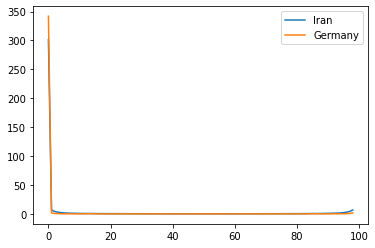

In [18]:
from scipy.fft import fft, ifft
# fig = plt.figure(figsize=(10, 5), dpi=80)
# gs = fig.add_gridspec(1, 2, hspace=0)
# axs = gs.subplots(sharex=True, sharey=True)

# axs[0].plot(country_datacum["Iran"][ROW_DEATH,:] , label = 'death')
# axs[0].plot(country_datacum["Iran"][ROW_CASE,:], label = 'case')
# axs[0].plot(country_datacum["Iran"][ROW_DEATH,:] / country_datacum["Iran"][ROW_CASE,:], label = 'diff')

# axs[1].plot(country_datacum["Germany"][ROW_DEATH,:] , label = 'death')
# axs[1].plot(country_datacum["Germany"][ROW_CASE,:], label = 'case')
# axs[1].plot(country_datacum["Germany"][ROW_DEATH,:] / country_datacum["Germany"][ROW_CASE,:], label = 'diff')

# plt.yscale('log',base=2) 


# plt.legend()

# infection_to_death = 30

dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'Iran')
plt.plot(np.abs(scipy.fft.fft(dd)), label='Iran')

dd = log_fatality_ratio_estimate_cum(300, n, infection_to_death, 'Germany')
plt.plot(np.abs(scipy.fft.fft(dd)), label='Germany')
plt.legend()

In [6]:
c = "Iran"

with open('data/daily.csv', 'w', newline='') as csvfile:
    fieldnames = ['date', 'state', 'positive', 'negative', 'pending', \
                  'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', \
                  'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', \
                  'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked', \
                  'death', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'fips', \
                  'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease', \
                  'totalTestResultsIncrease']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(n):
        d = first_date + datetime.timedelta(days=i)
        if d not in country_test_count[c]:
            test = 0
        else:
            test = country_test_count[c][d]
        writer.writerow({'date': d.strftime("%Y%m%d"), 'state': 'IR', \
                        'positive': country_data[c][ROW_CASE,i], \
                        'negative': test - country_data[c][ROW_CASE,i], \
                        'death': country_data[c][ROW_DEATH,i], \
                        'posNeg': test})
    




In [29]:
country_test_count["Iran"]

{datetime.date(2020, 4, 9): 10418,
 datetime.date(2020, 4, 10): 11175,
 datetime.date(2020, 4, 11): 9135,
 datetime.date(2020, 4, 12): 11685,
 datetime.date(2020, 4, 15): 11845,
 datetime.date(2020, 4, 16): 11136,
 datetime.date(2020, 4, 17): 9539,
 datetime.date(2020, 4, 18): 10258,
 datetime.date(2020, 4, 19): 11525,
 datetime.date(2020, 4, 20): 11350,
 datetime.date(2020, 4, 21): 12711,
 datetime.date(2020, 4, 24): 10420,
 datetime.date(2020, 4, 25): 10148,
 datetime.date(2020, 4, 26): 11238,
 datetime.date(2020, 4, 27): 11016,
 datetime.date(2020, 4, 30): 9909,
 datetime.date(2020, 5, 1): 11728,
 datetime.date(2020, 5, 2): 9518,
 datetime.date(2020, 5, 3): 11732,
 datetime.date(2020, 5, 4): 12015,
 datetime.date(2020, 5, 5): 11255,
 datetime.date(2020, 5, 6): 11732,
 datetime.date(2020, 5, 7): 13517,
 datetime.date(2020, 5, 8): 14107,
 datetime.date(2020, 5, 13): 14057,
 datetime.date(2020, 5, 14): 14238,
 datetime.date(2020, 5, 15): 14832,
 datetime.date(2020, 5, 16): 14075,
 date